In [59]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-y5bfkea_
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-y5bfkea_


In [60]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [61]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [62]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [63]:
CSV_FILE = "/content/object-localization-dataset/train.csv"
DATA_DIR = "/content/object-localization-dataset/"

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientresnet_b0'

NUM_COR = 4

In [64]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

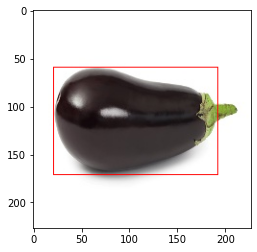

In [65]:
row = df.iloc[184]

img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

#ploting with bounding box

pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img,pt1,pt2,(255,0,0),1)
plt.imshow(bnd_box_img)

In [66]:
train_df, valid_df = train_test_split(df, test_size= 0.20, random_state= 42)

# Augmentations

In [67]:
import albumentations as A

In [68]:
from albumentations.augmentations.transforms import VerticalFlip
train_augs = A.Compose([
                        A.Resize(IMG_SIZE, IMG_SIZE),
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc',label_fields= ['class_labels']))

valid_augs = A.Compose([
                        A.Resize(IMG_SIZE, IMG_SIZE),
                        
], bbox_params = A.BboxParams(format = 'pascal_voc',label_fields= ['class_labels']))

# Create Custom Dataset

In [69]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self,df,augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data ['bboxes'][0]

    img = torch.from_numpy(img).permute(2,0,1)/255.0 #(h,w,c) -> (c,h,w)
    bbox = torch.Tensor(bbox)

    return img, bbox   





In [70]:
trainset = ObjLocDataset (train_df, train_augs)
validset = ObjLocDataset (valid_df, valid_augs)

In [71]:
print(f"Total exm in the trainset : {len(trainset)}")
print(f"Total exm in the validset : {len(validset)}")

Total exm in the trainset : 148
Total exm in the validset : 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


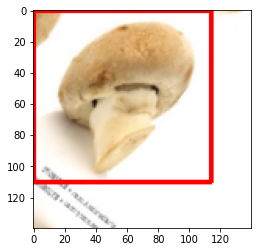

In [72]:
img, bbox = trainset[100]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [73]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [74]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [75]:
for images,bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [76]:
from torch import nn 
import timm

In [77]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel,self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained = True , num_classes = 4)

  def forward(self, images, gt_bboxes = None):

    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes      

In [78]:
model = ObjLocModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


ObjLocModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [79]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [80]:
def train_fn(model, dataloader,optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)  

In [81]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()
  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
      
      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()
      
    return total_loss/len(dataloader)  

#Training Loop

In [82]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [83]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model,trainloader,optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("WEIGHTS-ARE-SAVED")
    best_valid_loss = valid_loss

  print(f"EPOCH : {i + 1} train loss : {train_loss} valid loss : {valid_loss}")  

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 1 train loss : 7616.5212890625 valid loss : 6943.6220703125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 2 train loss : 7091.783935546875 valid loss : 5557.18701171875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 3 train loss : 6268.782470703125 valid loss : 3340.6082356770835


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 4 train loss : 4883.723388671875 valid loss : 1935.6000569661458


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 5 train loss : 3138.774755859375 valid loss : 1190.8301595052083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 6 train loss : 1608.5027648925782 valid loss : 423.9018046061198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 7 train loss : 570.576953125 valid loss : 271.2244873046875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 8 train loss : 253.76681213378907 valid loss : 293.4112040201823


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 9 train loss : 213.05193786621095 valid loss : 268.8990478515625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 10 train loss : 217.44427337646485 valid loss : 240.42381286621094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 11 train loss : 224.00016174316406 valid loss : 253.93587239583334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 12 train loss : 225.33410034179687 valid loss : 236.21260579427084


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 13 train loss : 180.0048400878906 valid loss : 236.39095052083334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 14 train loss : 179.19454193115234 valid loss : 222.35106404622397


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 15 train loss : 196.33321075439454 valid loss : 244.9645792643229


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 16 train loss : 184.7507110595703 valid loss : 283.1063537597656


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 17 train loss : 195.93631744384766 valid loss : 205.63346354166666


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 18 train loss : 168.05450820922852 valid loss : 169.25714111328125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 19 train loss : 158.67719268798828 valid loss : 170.8709462483724


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 20 train loss : 145.84503707885742 valid loss : 164.03023274739584


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 21 train loss : 145.00204696655274 valid loss : 164.60530853271484


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 22 train loss : 153.37253341674804 valid loss : 163.49639892578125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 23 train loss : 147.89261932373046 valid loss : 146.65083821614584


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 24 train loss : 127.34549713134766 valid loss : 136.6641057332357


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 25 train loss : 106.32351913452149 valid loss : 141.0719248453776


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 26 train loss : 114.69156875610352 valid loss : 114.56282043457031


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 27 train loss : 103.34496688842773 valid loss : 102.79797617594402


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 28 train loss : 121.47042083740234 valid loss : 97.70558166503906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 29 train loss : 105.88091430664062 valid loss : 111.1394551595052


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 30 train loss : 104.69356079101563 valid loss : 116.03829193115234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 31 train loss : 113.38006820678712 valid loss : 91.99051157633464


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 32 train loss : 109.41715698242187 valid loss : 99.78385925292969


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 33 train loss : 95.45342140197754 valid loss : 101.46349589029948


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 34 train loss : 96.14070281982421 valid loss : 120.23654683430989


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 35 train loss : 96.36322174072265 valid loss : 146.93827311197916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 36 train loss : 101.40815010070801 valid loss : 104.05953470865886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 37 train loss : 91.99484405517578 valid loss : 104.22510528564453


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 38 train loss : 93.4693790435791 valid loss : 135.44884236653647


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 39 train loss : 78.27853469848633 valid loss : 91.22472127278645


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH : 40 train loss : 84.55352935791015 valid loss : 90.39517466227214


#Inference

In [84]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


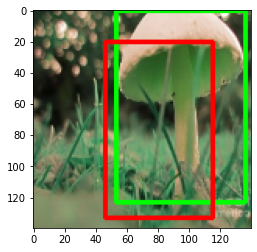

In [86]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():

  image, gt_bbox = validset[31] #(c,h,w)
  image = image.unsqueeze(0).to(DEVICE) #(bs,c,h,w)
  out_bbox = model(image)

  utils.compare_plots(image,gt_bbox,out_bbox)